In [37]:
import os

if "src" not in os.listdir():
    os.chdir("../../../")

import json

import numpy as np
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from dateutil import parser
import pandas as pd
# from pytz import timezone
import pickle
import warnings

import pandas_market_calendars as mcal
from keras.models import load_model

from src.lib.alpaca_historical import AlpacaData
from src.lib.alpaca_paper import AlpacaTrader
from src.lib.activations import negative_softmax
from src.lib.price_history import transform_price_history, PriceHistory
from src.lib.stock_dataset import read_stock_dataset
from src.lib.util import makedir_to
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
path = "results/4_lstm_long/"
keys = "alpaca_config.json"

In [39]:
api_data = AlpacaData(keys)

model = load_model(
    os.path.join(path, "model.h5"),
    custom_objects={
        "negative_softmax": negative_softmax
    }
)

with open(os.path.join(path, "config.json"), "r") as f:
    config = json.load(f)

n_time_steps = config["n_time_steps"]
symbols = config["symbols"]
target_column = config["target_column"]

with open(os.path.join(path, "scaler.pkl"), "rb") as f:
    scaler = pickle.load(f)

for symbol in symbols:
    api_data.update_saved_data(symbol)

dataset = read_stock_dataset(symbols, target_column, n_time_steps)
dataset = dataset.apply_standard_scaler(scaler)

with open(os.path.join(path, "trade_log.txt"), "r") as f:
    trade_log = f.readlines()

equity_history = np.array([
    float(line.split(",")[-1].strip())
    for line in trade_log
])
equity_history /= equity_history[0]

log_index = np.array([
    parser.parse(line.split(",")[0].strip()).replace(second=0, microsecond=0)
    for line in trade_log
])



2021-09-22 22:46:00+00:00:  99%|█████████▉| 99.39/100 [00:00<00:00, 399.12it/s]
2021-09-22 22:46:00+00:00:  99%|█████████▉| 99.36/100 [00:00<00:00, 488.37it/s]


In [40]:
# live_preds = np.zeros((len(trade_log), len(symbols)))
# for i, line in enumerate(trade_log):
#     parts = line.split(",")
#     string = ",".join([parts[1], parts[2]]).replace("'", "\"")
#     holding_dict = json.loads(string)
#     for j, symbol in enumerate(symbols):
#         live_preds[i, j] = holding_dict[symbol]

# # live_preds = live_preds[[
# #     i
# #     for i, time in enumerate(equity.index)
# #     if time in dataset.X.index
# # ]]
# live_preds = live_preds[range(len(equity))]
# len(live_preds)

372

In [75]:


equity = pd.Series(equity_history, index=log_index, name="equity")
time_index = [
    time
    for time in equity.index
    if time in dataset.X.index
]
equity = equity[time_index]

live_preds = np.zeros((len(trade_log), len(symbols)))
for i, line in enumerate(trade_log):
    parts = line.split(",")
    string = ",".join([parts[1], parts[2]]).replace("'", "\"")
    holding_dict = json.loads(string)
    for j, symbol in enumerate(symbols):
        live_preds[i, j] = holding_dict[symbol]
live_preds = live_preds[range(len(equity))]

start_ind = dataset.X.index.get_loc(equity.index[0])
end_ind = len(dataset.X)
int_index = [
    v
    for k, v in enumerate(range(start_ind, end_ind))
    if equity.index[k] in dataset.X.index
]

X, y = dataset.get_batch(len(int_index), int_index, shuffle=False, replace=False)

In [48]:
preds = model.predict(X)
rets = np.exp((np.log(preds*y + 1)).sum(axis=-1).cumsum())
rets_live_preds = np.exp((np.log(live_preds*y + 1)).sum(axis=-1).cumsum())

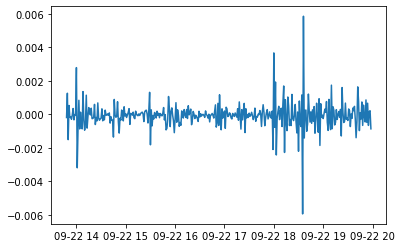

-6.710221816439459e-05
0.0007840045814357467
11.683735692835128


In [51]:
change_diff = np.diff(equity)/equity[:-1] - np.diff(rets_live_preds)/rets_live_preds[:-1]
plt.plot(change_diff)
plt.show()
print(change_diff.mean())
print(change_diff.std())
print(abs(change_diff.std()/change_diff.mean()))

In [85]:
# adj_rets = np.exp(((np.log(live_preds*y + 1)).sum(axis=-1)[:-1] + np.log(1+change_diff)).cumsum())
adj_rets = ((live_preds*y + 1).prod(-1) * (1 + change_diff[:len(change_diff)//2].mean())).cumprod()

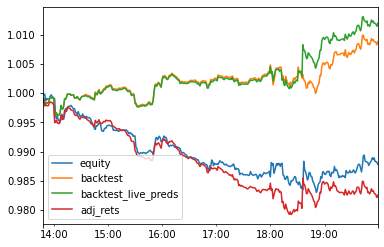

In [86]:
performance = pd.DataFrame({
    "equity": equity,
    "backtest": rets,
    "backtest_live_preds": rets_live_preds,
    "adj_rets": adj_rets
}, index=time_index)
performance.plot()
plt.show()